# Librerías necesarias para trabajar

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix
import json
import os
from tqdm import tqdm

# Carga de datos

In [ ]:
from google.colab import drive

# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Definir rutas
ruta_zip_en_drive = "/content/drive/MyDrive/data_pet_adoption.zip"
ruta_destino_local = "/content/dataset_local"

# 3. Copiar y Descomprimir (Solo si no lo has hecho ya)
if not os.path.exists(ruta_destino_local):
    print("Copiando y descomprimiendo datos... (esto puede tardar un poco)")

    # Creamos la carpeta local
    os.makedirs(ruta_destino_local, exist_ok=True)

    # Comando de sistema para descomprimir rápido
    # -q es para que no imprima miles de líneas (quiet)
    # -d es el destino
    !unzip -q "{ruta_zip_en_drive}" -d "{ruta_destino_local}"

    print("¡Datos listos en el entorno local!")
else:
    print("Los datos ya estaban descomprimidos.")

Mounted at /content/drive
Copiando y descomprimiendo datos... (esto puede tardar un poco)
¡Datos listos en el entorno local!


# EDA

## train.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/train.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 14993 filas x 24 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2



--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


## color_labels.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/color_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 7 filas x 2 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream



--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ColorID    7 non-null      int64 
 1   ColorName  7 non-null      object
dtypes: int64(1), object(1)
memory usage: 244.0+ bytes

--- 3. DESCRIBE (Estadísticas) ---


,ColorID
count,7.000000
mean,4.000000
std,2.160247
min,1.000000
25%,2.500000
50%,4.000000
75%,5.500000
max,7.000000


## state_labels.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/state_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 15 filas x 2 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan



--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   StateID    15 non-null     int64 
 1   StateName  15 non-null     object
dtypes: int64(1), object(1)
memory usage: 372.0+ bytes

--- 3. DESCRIBE (Estadísticas) ---


,StateID
count,15.000000
mean,41349.733333
std,29.001149
min,41324.000000
25%,41328.500000
50%,41336.000000
75%,41364.000000
max,41415.000000


## breed_labels

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/breed_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 307 filas x 3 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita



--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   BreedID    307 non-null    int64 
 1   Type       307 non-null    int64 
 2   BreedName  307 non-null    object
dtypes: int64(2), object(1)
memory usage: 7.3+ KB

--- 3. DESCRIBE (Estadísticas) ---


,BreedID,Type
count,307.000000,307.000000
mean,154.000000,1.214984
std,88.767487,0.411482
min,1.000000,1.000000
25%,77.500000,1.000000
50%,154.000000,1.000000
75%,230.500000,1.000000
max,307.000000,2.000000


## train_sentiment.csv

In [ ]:
import pandas as pd
import json
import os
from tqdm.notebook import tqdm

# 1. Definir la ruta
sentiment_path = '/content/dataset_local/petfinder-adoption-prediction/train_sentiment'

# 2. Preparamos una lista para guardar los datos
sentiment_data = []

# 3. Obtenemos la lista de archivos (limitamos a .json)
files = [f for f in os.listdir(sentiment_path) if f.endswith('.json')]

print(f"📂 Encontrados {len(files)} archivos de sentimiento. Procesando...")

# 4. Bucle para leer cada archivo
for filename in tqdm(files):
    file_path = os.path.join(sentiment_path, filename)

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            json_content = json.load(f)

        # Extraemos lo que nos interesa
        # El PetID es el nombre del archivo sin el ".json"
        pet_id = filename.split('.')[0]

        # Datos del JSON
        score = json_content['documentSentiment']['score']
        magnitude = json_content['documentSentiment']['magnitude']
        language = json_content['language']

        # Guardamos en la lista
        sentiment_data.append({
            'PetID': pet_id,
            'SentimentScore': score,
            'SentimentMagnitude': magnitude,
            'Language': language
        })

    except Exception as e:
        print(f"Error leyendo {filename}: {e}")

# 5. Convertimos la lista a DataFrame
df_sentiment = pd.DataFrame(sentiment_data)

print("✅ Tabla de Sentimientos creada exitosamente.")

# --- A. VISTA PREVIA ---
print("\n--- 1. PRIMERAS FILAS ---")
display(df_sentiment.head())

# --- B. ESTADÍSTICAS DEL SENTIMIENTO ---
print("\n--- 2. ESTADÍSTICAS (Score y Magnitud) ---")
# Esto es crucial:
# - Si la media del Score es cercana a 1, todo el mundo habla bien de sus mascotas.
# - Si la Magnitud media es baja, las descripciones son muy cortas o secas.
display(df_sentiment[['SentimentScore', 'SentimentMagnitude']].describe())

# --- C. IDIOMAS ---
print("\n--- 3. IDIOMAS DETECTADOS ---")
# ¿Están todos en inglés ('en')? ¿Hay alguno en malayo ('ms')?
idiomas = df_sentiment['Language'].value_counts()
display(idiomas)

# --- D. TIPOS DE DATOS ---
print("\n--- 4. INFO TÉCNICA ---")
df_sentiment.info()

📂 Encontrados 14442 archivos de sentimiento. Procesando...


  0%|          | 0/14442 [00:00<?, ?it/s]

✅ Tabla de Sentimientos creada exitosamente.

--- 1. PRIMERAS FILAS ---


,PetID,SentimentScore,SentimentMagnitude,Language
0,ebba4f83b,0.0,0.0,en
1,b022c1924,0.1,1.3,en
2,7fc640ad8,0.7,5.6,en
3,bd05c2f75,0.1,2.9,en
4,e0ad66343,-0.1,1.2,en



--- 2. ESTADÍSTICAS (Score y Magnitud) ---


,SentimentScore,SentimentMagnitude
count,14442.000000,14442.000000
mean,0.280951,2.127628
std,0.276766,2.036914
min,-0.900000,0.000000
25%,0.100000,0.800000
50%,0.300000,1.600000
75%,0.400000,2.800000
max,0.900000,32.000000



--- 3. IDIOMAS DETECTADOS ---


,count
Language,
en,14309
zh,95
zh-Hant,36
de,2



--- 4. INFO TÉCNICA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442 entries, 0 to 14441
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PetID               14442 non-null  object 
 1   SentimentScore      14442 non-null  float64
 2   SentimentMagnitude  14442 non-null  float64
 3   Language            14442 non-null  object 
dtypes: float64(2), object(2)
memory usage: 451.4+ KB


# Pipeline ETL: Preprocesamiento y Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
import json
import os
from tqdm.notebook import tqdm

# Configuración visual
pd.set_option('display.max_columns', None)
tqdm.pandas()

# =============================================================================
# 1. CONFIGURACIÓN DE RUTAS
# =============================================================================
PATHS = {
    'train': '/content/dataset_local/petfinder-adoption-prediction/train.csv',
    'breeds': '/content/dataset_local/petfinder-adoption-prediction/breed_labels.csv',
    'colors': '/content/dataset_local/petfinder-adoption-prediction/color_labels.csv',
    'states': '/content/dataset_local/petfinder-adoption-prediction/state_labels.csv',
    'sentiment_dir': '/content/dataset_local/petfinder-adoption-prediction/train_sentiment'
}

# =============================================================================
# 2. CARGA DE DATOS Y CORRECCIÓN PREVENTIVA
# =============================================================================
print("🚀 Iniciando Pipeline Maestro...")

# Cargar CSVs
df_main = pd.read_csv(PATHS['train'])
df_breeds = pd.read_csv(PATHS['breeds'])
df_colors = pd.read_csv(PATHS['colors'])
df_states = pd.read_csv(PATHS['states'])

print(f"   - Dataset original: {df_main.shape}")

# --- FIX CRÍTICO: COLUMNA 'TYPE' ---
# El archivo de razas también tiene una columna 'Type'. Si no la quitamos antes de
# unir, Pandas creará conflictos y corromperá la columna Type original.
if 'Type' in df_breeds.columns:
    df_breeds = df_breeds.drop('Type', axis=1)

# =============================================================================
# 3. FUSIÓN DE DATOS (ENRICHMENT)
# =============================================================================

# A. Razas (Traemos los nombres para Master, mantenemos IDs para ML)
df_main = df_main.merge(df_breeds, left_on='Breed1', right_on='BreedID', how='left')
df_main.rename(columns={'BreedName': 'Breed1_Name'}, inplace=True)
df_main.drop('BreedID', axis=1, inplace=True)

df_main = df_main.merge(df_breeds, left_on='Breed2', right_on='BreedID', how='left')
df_main.rename(columns={'BreedName': 'Breed2_Name'}, inplace=True)
df_main.drop('BreedID', axis=1, inplace=True)

# B. Colores
for i in [1, 2, 3]:
    col_name = f'Color{i}'
    df_main = df_main.merge(df_colors, left_on=col_name, right_on='ColorID', how='left')
    df_main.rename(columns={'ColorName': f'{col_name}_Name'}, inplace=True)
    df_main.drop('ColorID', axis=1, inplace=True)

# C. Estados
df_main = df_main.merge(df_states, left_on='State', right_on='StateID', how='left')
df_main.rename(columns={'StateName': 'State_Name'}, inplace=True)
df_main.drop('StateID', axis=1, inplace=True)

print("✅ Tablas fusionadas correctamente (sin perder 'Type').")

# =============================================================================
# 4. EXTRACCIÓN DE SENTIMIENTOS (NLP)
# =============================================================================
print("⏳ Procesando Sentimientos (JSON)...")

def extract_sentiment(pet_id):
    path = os.path.join(PATHS['sentiment_dir'], f"{pet_id}.json")
    score, magnitude, language = 0, 0, 'en'

    if os.path.exists(path):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                score = data['documentSentiment']['score']
                magnitude = data['documentSentiment']['magnitude']
                language = data['language']
        except:
            pass
    return pd.Series([score, magnitude, language])

df_main[['SentimentScore', 'SentimentMagnitude', 'Language']] = df_main['PetID'].progress_apply(extract_sentiment)

# =============================================================================
# 5. FEATURE ENGINEERING (INGENIERÍA DE CARACTERÍSTICAS)
# =============================================================================
print("🛠️ Creando Variables Derivadas...")

# A. Variables de Texto
invalid_names = ['no name', 'noname', 'none', 'na', 'unknown', 'sin nombre', '0']
df_main['HasName'] = df_main['Name'].apply(
    lambda x: 0 if pd.isna(x) or str(x).lower().strip() in invalid_names or len(str(x)) < 2 else 1
)
df_main['DescWordCount'] = df_main['Description'].fillna("").apply(lambda x: len(str(x).split()))

# B. Variables Biológicas (Mestizaje y Edad)
df_main['IsMixedBreed'] = df_main.apply(
    lambda x: 1 if (x['Breed1'] == 307 or x['Breed2'] == 307 or (x['Breed2'] != 0 and x['Breed1'] != x['Breed2'])) else 0, axis=1
)
df_main['AgeBin'] = pd.cut(df_main['Age'], bins=[-1, 3, 12, 60, 255], labels=[0, 1, 2, 3]).astype(int)

# C. Variables Económicas y Multimedia
df_main['IsFree'] = (df_main['Fee'] == 0).astype(int)
df_main['TotalMultimedia'] = df_main['PhotoAmt'] + df_main['VideoAmt']

# D. Sentimiento Avanzado
df_main['SentimentImpact'] = df_main['SentimentScore'] * df_main['SentimentMagnitude']

# =============================================================================
# 6. LIMPIEZA FINAL Y CREACIÓN DE DATASETS
# =============================================================================

# --- A. Guardar MASTER (Humano) ---
# Rellenamos nulos visuales para el CSV maestro
df_master = df_main.copy()
text_cols = ['Breed1_Name', 'Breed2_Name', 'Color1_Name', 'Color2_Name', 'Color3_Name', 'State_Name']
for col in text_cols:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna("None")

df_master['Name'].fillna("No Name", inplace=True)
df_master['Description'].fillna("", inplace=True)

df_master.to_csv('master.csv', index=False)
print(f"📄 'master.csv' generado. (Contiene texto legible y {df_master.shape[0]} filas)")


# --- B. Guardar TRAIN READY (Máquina) ---
print("🧹 Preparando dataset numérico para LightGBM...")
df_model = df_master.copy()

# 1. Eliminamos columnas de TEXTO o IDs inútiles para el modelo
cols_to_drop = [
    'Name', 'Description', 'PetID', 'RescuerID',  # Texto libre / IDs únicos
    'Breed1_Name', 'Breed2_Name',                 # Redundantes (ya tenemos Breed1 ID)
    'Color1_Name', 'Color2_Name', 'Color3_Name',  # Redundantes (ya tenemos Color1 ID)
    'State_Name', 'Language'                      # Texto
]
# Solo borramos si existen
df_model.drop(columns=[c for c in cols_to_drop if c in df_model.columns], inplace=True)

# 2. Encoding manual de lo que falta
# State era texto en master, necesitamos recuperar el ID o codificarlo.
# Como borramos StateID al inicio, usamos el State_Name recuperado en Master, pero para el modelo
# lo transformamos a número.
if 'State_Name' in df_main.columns:
     # Usamos Label Encoding sobre el dataframe original antes de borrar
     df_model['State'] = df_main['State_Name'].astype('category').cat.codes

# 3. Asegurar tipos numéricos (Ints donde corresponda)
cols_int = ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
            'Sterilized', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
for col in cols_int:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(int)

# Guardar
df_model.to_csv('train_ready.csv', index=False)

print("="*60)
print(f"🎉 ¡TODO LISTO! Archivo para entrenar: 'train_ready.csv'")
print(f"📊 Dimensiones para el modelo: {df_model.shape}")
print(f"⚠️ Nulos restantes en el modelo: {df_model.isnull().sum().sum()} (Debería ser 0)")
print("="*60)

# Muestra final del dataset numérico
display(df_model.head(3))

🚀 Iniciando Pipeline Maestro...
   - Dataset original: (14993, 24)
✅ Tablas fusionadas correctamente (sin perder 'Type').
⏳ Procesando Sentimientos (JSON)...


  0%|          | 0/14993 [00:00<?, ?it/s]

🛠️ Creando Variables Derivadas...


/tmp/ipython-input-4169584460.py:127: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master['Name'].fillna("No Name", inplace=True)
/tmp/ipython-input-4169584460.py:128: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

📄 'master.csv' generado. (Contiene texto legible y 14993 filas)
🧹 Preparando dataset numérico para LightGBM...
🎉 ¡TODO LISTO! Archivo para entrenar: 'train_ready.csv'
📊 Dimensiones para el modelo: (14993, 29)
⚠️ Nulos restantes en el modelo: 0 (Debería ser 0)


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,SentimentScore,SentimentMagnitude,HasName,DescWordCount,IsMixedBreed,AgeBin,IsFree,TotalMultimedia,SentimentImpact
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,12,0,1,2,0.3,2.4,1,69,0,0,0,1.0,0.72
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,3,0,2,0,-0.2,0.7,1,23,0,0,1,2.0,-0.14
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,12,0,7,3,0.2,3.7,1,69,1,0,1,7.0,0.74


# Entrenamiento del modelo

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import scipy.optimize as sp
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, mean_squared_error

# Configuración para que el output sea limpio
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# 1. CARGA DE DATOS
# =============================================================================
print("📥 Cargando dataset preparado...")
df_train = pd.read_csv('train_ready.csv')

# Separamos X (Variables) e y (Objetivo)
X = df_train.drop(['AdoptionSpeed'], axis=1)
y = df_train['AdoptionSpeed']

# Convertimos a array numpy para evitar problemas de índices en KFold
X_values = X.values
y_values = y.values

print(f"✅ Datos listos: {X.shape[0]} filas, {X.shape[1]} columnas.")

# =============================================================================
# 2. HERRAMIENTA DE CORTE (OPTIMIZED ROUNDER)
# =============================================================================
# Esta clase busca los mejores puntos de corte para convertir regresión a clases
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        # Rompe la predicción continua en clases usando los cortes (coef)
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        # Calculamos QWK. Negativo porque scipy busca minimizar, y nosotros queremos maximizar kappa
        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        # Cortes iniciales estándar (0.5, 1.5, 2.5, 3.5)
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Scipy minimiza la función de pérdida buscando los mejores coeficientes
        self.coef_ = sp.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p.astype(int)

from functools import partial

# =============================================================================
# 3. MOTOR DE OPTIMIZACIÓN (OPTUNA + CV)
# =============================================================================
def objective(trial):
    # --- A. Espacio de Hiperparámetros (Optuna elige aquí) ---
    params = {
        'objective': 'rmse',  # Usamos regresión (Root Mean Squared Error)
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
    }

    # --- B. Validación Cruzada (K-Fold) ---
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Guardamos las predicciones de validación (Out-Of-Fold)
    oof_preds = np.zeros(len(X))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_values, y_values)):
        X_train, X_val = X_values[train_idx], X_values[val_idx]
        y_train, y_val = y_values[train_idx], y_values[val_idx]

        # Crear dataset de LightGBM
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        # Entrenar modelo (con Early Stopping para no sobreajustar)
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        model = lgb.train(params, train_data, num_boost_round=2000,
                          valid_sets=[val_data], callbacks=callbacks)

        # Predecir en validación (valor continuo)
        oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)

    # --- C. Optimizar Cortes y Calcular QWK ---
    optR = OptimizedRounder()
    optR.fit(oof_preds, y_values) # Buscamos los cortes óptimos con las predicciones
    coefficients = optR.coef_['x']

    # Convertimos predicción continua a clases usando los cortes optimizados
    val_predictions_class = optR.predict(oof_preds, coefficients)

    # Calculamos la métrica final
    qwk = cohen_kappa_score(y_values, val_predictions_class, weights='quadratic')

    return qwk

# =============================================================================
# 4. EJECUCIÓN
# =============================================================================
print("🚀 Iniciando búsqueda de Hiperparámetros con Optuna...")
print("   (Esto puede tardar unos minutos, estamos probando 20 combinaciones)")

study = optuna.create_study(direction='maximize') # Queremos maximizar QWK
study.optimize(objective, n_trials=20) # 20 intentos (sube a 50 o 100 para más precisión)

print("\n🏆 MEJORES RESULTADOS ENCONTRADOS:")
print(f"   Best QWK Score: {study.best_value:.5f}")
print("   Best Params:", study.best_params)

# =============================================================================
# 5. ENTRENAMIENTO FINAL (ENSEMBLE)
# =============================================================================
print("\n🛠️ Entrenando los 5 modelos finales con los mejores parámetros...")

best_params = study.best_params
best_params['objective'] = 'rmse'
best_params['metric'] = 'rmse'
best_params['random_state'] = 42
best_params['verbosity'] = -1

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
oof_preds_final = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_values, y_values)):
    print(f"   -> Entrenando Fold {fold+1}/5...")
    X_train, X_val = X_values[train_idx], X_values[val_idx]
    y_train, y_val = y_values[train_idx], y_values[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    callbacks = [lgb.log_evaluation(period=0), lgb.early_stopping(stopping_rounds=100)]
    model = lgb.train(best_params, train_data, num_boost_round=5000,
                      valid_sets=[val_data], callbacks=callbacks)

    models.append(model)
    # Guardamos predicciones para recalcular los cortes definitivos
    oof_preds_final[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)

# Calculamos los cortes definitivos (Thresholds)
print("\n📐 Calculando Cortes Óptimos Finales...")
optR_final = OptimizedRounder()
optR_final.fit(oof_preds_final, y_values)
final_coefficients = optR_final.coef_['x']

final_qwk = cohen_kappa_score(y_values, optR_final.predict(oof_preds_final, final_coefficients), weights='quadratic')

print("="*60)
print(f"🎉 ENTRENAMIENTO COMPLETADO.")
print(f"📊 CV QWK Final del Ensemble: {final_qwk:.5f}")
print(f"✂️ Cortes Óptimos aprendidos: {final_coefficients}")
print("="*60)

📥 Cargando dataset preparado...
✅ Datos listos: 14993 filas, 28 columnas.
🚀 Iniciando búsqueda de Hiperparámetros con Optuna...
   (Esto puede tardar unos minutos, estamos probando 20 combinaciones)

🏆 MEJORES RESULTADOS ENCONTRADOS:
   Best QWK Score: 0.42097
   Best Params: {'learning_rate': 0.02807254792000721, 'num_leaves': 87, 'max_depth': 13, 'min_data_in_leaf': 23, 'lambda_l1': 1.6835487251381345, 'lambda_l2': 1.6061851712931308, 'bagging_fraction': 0.7957250707289041, 'feature_fraction': 0.6011964584361033}

🛠️ Entrenando los 5 modelos finales con los mejores parámetros...
   -> Entrenando Fold 1/5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[292]	valid_0's rmse: 1.05703
   -> Entrenando Fold 2/5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	valid_0's rmse: 1.04731
   -> Entrenando Fold 3/5...
Training until validation scores don't improve for 100 rounds
Early sto

# Importancia de variables

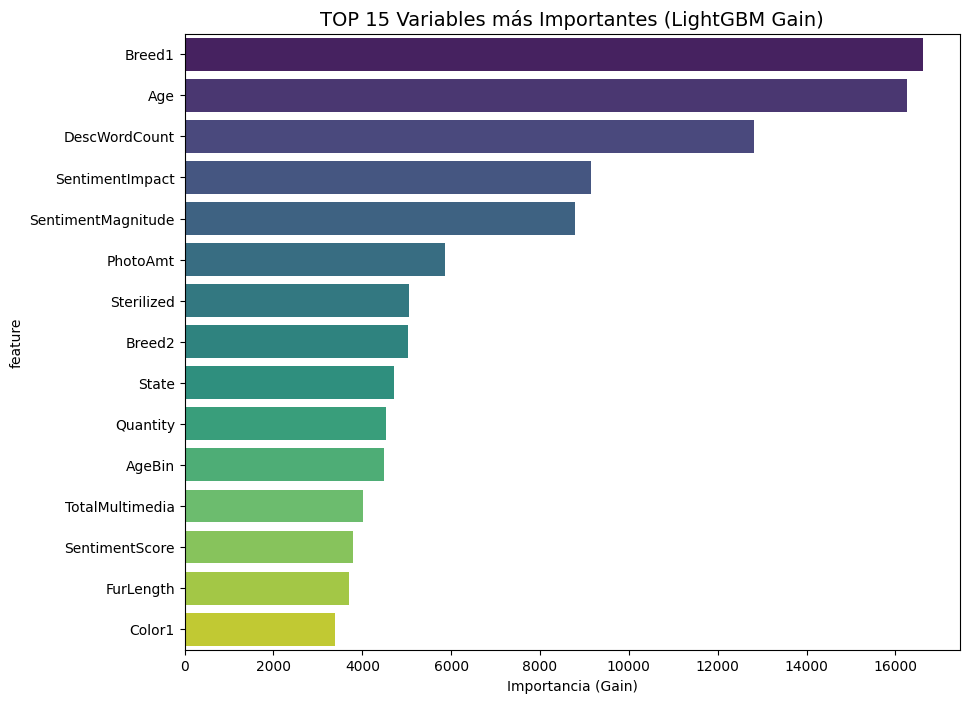

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extraemos la importancia de características del promedio de los 5 modelos
feature_importance = pd.DataFrame()
for i, model in enumerate(models):
    df_imp = pd.DataFrame()
    df_imp['feature'] = X.columns
    df_imp['importance'] = model.feature_importance(importance_type='gain') # 'gain' es más preciso que 'split'
    df_imp['fold'] = i
    feature_importance = pd.concat([feature_importance, df_imp])

# Promedio de los 5 folds
top_features = feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).head(15)

# Gráfico
plt.figure(figsize=(10, 8))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('TOP 15 Variables más Importantes (LightGBM Gain)', fontsize=14)
plt.xlabel('Importancia (Gain)')
plt.show()

# Guardamos el modelo

In [ ]:
import pickle

# Creamos un diccionario con todo lo necesario para predecir
artefactos_modelo = {
    'models': models,                 # La lista de los 5 LightGBMs
    'coeficientes': final_coefficients, # Los cortes [0.44, 2.16...]
    'features': X.columns.tolist()    # El orden exacto de columnas
}

# Guardar en disco
with open('modelo_petfinder_ensemble.pkl', 'wb') as f:
    pickle.dump(artefactos_modelo, f)

print("💾 ¡Modelo guardado! Archivo: 'modelo_petfinder_ensemble.pkl'")
print("   Contiene el ensemble de 5 modelos y los cortes optimizados.")

💾 ¡Modelo guardado! Archivo: 'modelo_petfinder_ensemble.pkl'
   Contiene el ensemble de 5 modelos y los cortes optimizados.


# Inferencia

In [ ]:
def predecir_mascotas(nuevo_df, artefactos_path='modelo_petfinder_ensemble.pkl'):
    """
    Toma un DataFrame procesado (train_ready format) y devuelve las clases (0-4).
    """
    # 1. Cargar el cerebro
    with open(artefactos_path, 'rb') as f:
        data = pickle.load(f)

    models_loaded = data['models']
    cuts = data['coeficientes']
    feats = data['features']

    # 2. Asegurar que usamos las mismas columnas
    X_new = nuevo_df[feats].values

    # 3. Predicción Ensemble (Promedio de 5 modelos)
    # Generamos matriz de (N_filas, 5_modelos)
    preds_matrix = np.zeros((len(X_new), len(models_loaded)))

    for i, model in enumerate(models_loaded):
        preds_matrix[:, i] = model.predict(X_new, num_iteration=model.best_iteration)

    # Promedio fila a fila (Regresión media)
    avg_preds = preds_matrix.mean(axis=1)

    # 4. Aplicar Cortes Optimizados
    optR = OptimizedRounder() # Usamos la clase que definimos arriba
    final_classes = optR.predict(avg_preds, cuts)

    return final_classes

print("✅ Función de inferencia lista.")
# Ejemplo de uso (simulado con datos de train):
# predicciones = predecir_mascotas(df_train)

✅ Función de inferencia lista.
